# Exercises

---

In [1]:
# connect to git to load all libraries and data

# get all files from the notebook here
!rm -rf population-methods-IT
!git clone https://github.com/irenetiem/population-methods-IT

import numpy as np
from scipy import io
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("population-methods-IT/03-dimensionality-reduction/code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

# download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/uh8XZNenSfuR2fq')

Cloning into 'population-methods-IT'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 228 (delta 28), reused 34 (delta 12), pack-reused 160 (from 1)
Receiving objects: 100% (228/228), 18.00 MiB | 22.43 MiB/s, done.
Resolving deltas: 100% (96/96), done.


## Exercise 1: structured and ustructured images
Write a function that outputs the number of PC you have to choose to retain a given percentage of explained variance.
Use this funtion on the  handwritten digit data, and plot the number of PC needed to retain a certain fraction of EVR, for a few vaules of EVR.

Compare this curve to the one you can obtain in unstructured images: either generate images with the same shape of our data or randomly permute the pixels in each image independenlty. How does the number of PC needed to retain a certain fraction of the variance in this case compare to the number needed for digit images?

In [2]:
# function to output the number of PC to choose to retain a given percentage
# of explained variance

def num_PC(dataset, percentage):
  """func that returns the number of PC to choose to retain a given percentage
  of explained variance

  input
  dataset: eg. MNIST digit data
  percentage: float, perfered percentage"""

  # load the data and perform PCA
  images = dataset.data

  scaler = StandardScaler()
  X =scaler.fit_transform(images)

  pca = PCA()
  pca.fit(X)

  total = 0

  for i in range(len(pca.explained_variance_ratio_)):
    total += pca.explained_variance_ratio_[i]
    if total >= percentage:
      return i+1

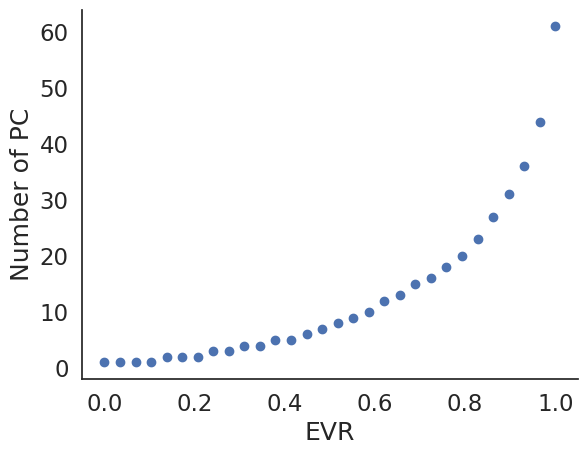

In [4]:
# testing a few EVR

# load image data (from notebook)
dataset = load_digits()

EVR = np.linspace(0, 1, 30)

PC_for_EVR = [num_PC(dataset, EVR[i]) for i in range(len(EVR))]

plt.scatter(EVR, PC_for_EVR)
plt.xlabel('EVR')
plt.ylabel('Number of PC')
plt.show()

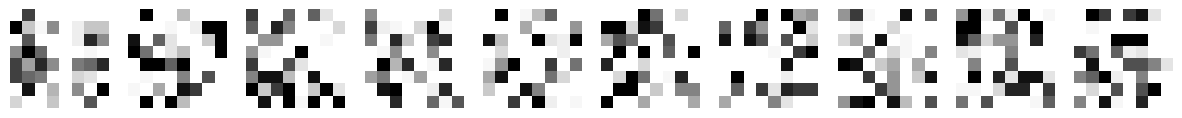

In [5]:
# comparing it with unstructered images by randmly permuting pixels from dataset

# load image data
dataset = load_digits()
images = dataset.data
images_permuted = np.copy(images)

# permute all pixels within single images
for image in range(len(images[0])):
    images_permuted[image] = np.random.permutation(images[image])

#plot first 10 images to check
plt.figure(figsize=(15,7))
for i,img in enumerate(images_permuted[:10]):
    plt.subplot(1,10,i+1)
    plt.imshow(img.reshape(8,8),cmap=plt.cm.Greys)
    plt.axis('off')

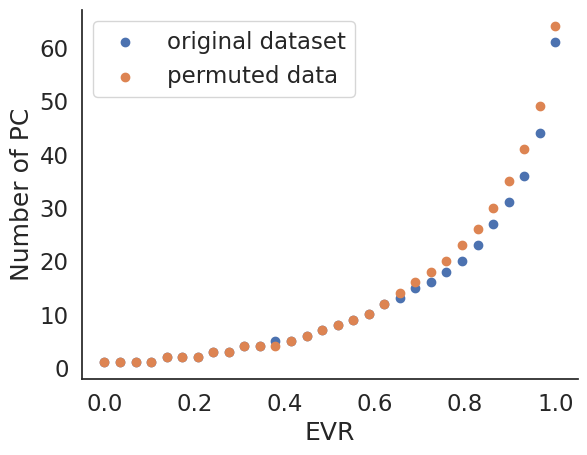

In [6]:
# now do the same for this permuted dataset

PC_for_EVR_perm = [num_PC(images_permuted, EVR[i]) for i in range(len(EVR))]

plt.scatter(EVR, PC_for_EVR, label = 'original dataset')
plt.scatter(EVR, PC_for_EVR_perm, label = 'permuted data')
plt.xlabel('EVR')
plt.ylabel('Number of PC')
plt.legend()
plt.show()

The plots for both the original data and permuted data look very similar, only near the end some small changes are visible, but I think these can be neglected. It needs slightly more PCs to get high PCs, but that might be because the images are more random than the digits.

## Exercise 2: cortical dynamics

Work with the cortical data we used in the lesson. Write some code that lets you easily chose a specific behavioural event from the `trial_data` dictionary (the recorded events are `CSp` for positive conditioned stimulus, `CSn` for negative conditioned stimulus and `licks` for lick events), one of the principal components, an onset time and and offset time, and plots the timecourse of this component in the selected period around the chosen event type.

Use this code to explore the data: how do different components behave? Do you notice any patterns? How would you test for the statistical significance of the effects that you see (if any)?

In [7]:
# load the cortical data
import pickle

with open('./data/behaviour.pickle', 'rb') as handle:
    trial_data = pickle.load(handle)

voltage_signal = np.load('./data/voltage_signal.npy')
cortex_mask = np.load('./data/cortex_mask.npy')

from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d


<ipython-input-7-c665f08e78b2>:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  trial_data = pickle.load(handle)


In [26]:
# get keys from trial_data
trial_data.keys()

dict_keys(['CSp', 'CSn', 'Lick', 'frames'])

In [20]:
# make the function

def timecourse_plot(behav_event, PC, onset, offset):
  """code that lets you easily chose a specific behavioural event from the
  trial_data dictionary (the recorded events are CSp for positive conditioned
  stimulus, CSn for negative conditioned stimulus and licks for lick events),
  one of the principal components, an onset time and and offset time, and plots
  the timecourse of this component in the selected period around the chosen
  event type

  args:
  PC: int
  behav_event: one of dict_keys(['CSp', 'CSn', 'Lick', 'frames']), but not frames"""

  # PCA the data
  X = voltage_signal.transpose(2,0,1)
  T,h,w = X.shape
  X = X[:,cortex_mask]
  pca = PCA(n_components=PC+2); # higher values are not needed
  pca.fit(X)

  # prpare for plot
  # code taken from notebook
  framerate = 50. #in Hz
  start_time = onset
  end_time = offset
  frame_times = trial_data['frames'] #frame times

  PCs = pca.components_[:PC+2, :].T # select and transpose wanted PC (+2) weights
  Y = X @ PCs # compute the PC timecourse, by projecting the original data on each component

  peri_Y = [] #empty list for timecourses

  #cycle
  for i in trial_data[behav_event]:
      onset_frame = np.argmin(abs(frame_times-i)) #take frame closest to onset
      start_frame = int(onset_frame + framerate*start_time/1.000) # compute starting frame
      end_frame = int(onset_frame + framerate*end_time/1.000) # compute ending frame
      peri_Y.append(Y[start_frame:end_frame]) #saves the slice of Y

  peri_Y = np.asarray(peri_Y)

  mean_Y = np.mean(peri_Y,axis=0) #average
  error = sem(peri_Y,axis=0) #compute sem

  # plot it
  comp = PC

  plt.figure(figsize=(8,4))
  t = np.linspace(start_time,end_time,int((end_time-start_time)*framerate))
  y = mean_Y[:,comp-1]
  err = error[:,comp-1]

  y = gaussian_filter1d(y,2)
  err = gaussian_filter1d(err,2)

  plt.plot(t,y)
  plt.title('PC = {}'.format(PC))
  plt.fill_between(t,y-err,y+err,alpha=0.2)
  plt.xlabel('Time (s)')
  plt.ylabel('PC activation (a.u.)')
  plt.axvline(x=0,linestyle='--',label='event onset')
  plt.legend()
  plt.show()

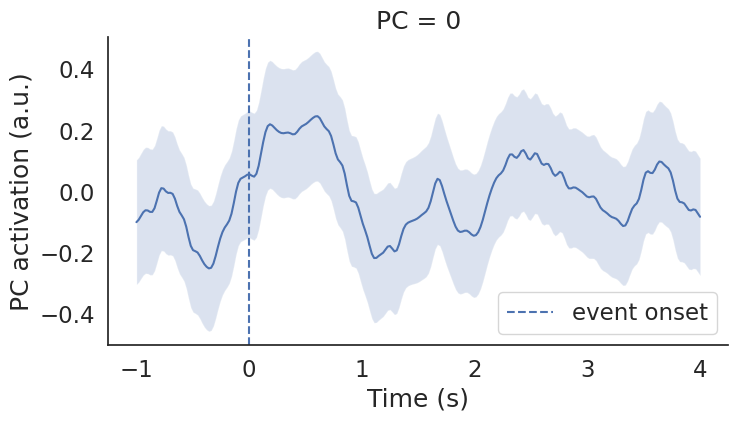

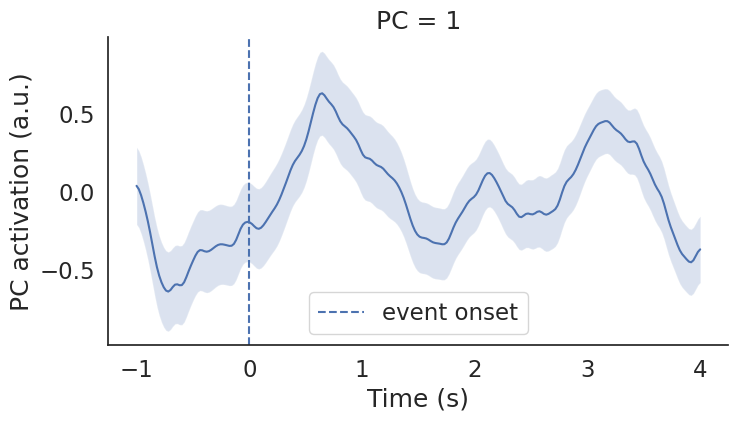

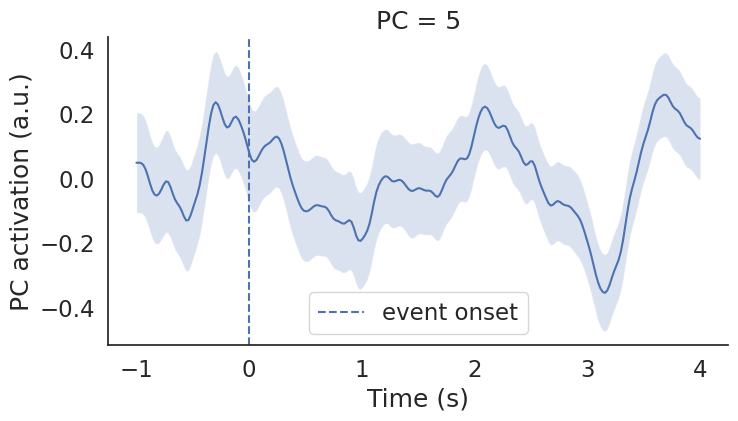

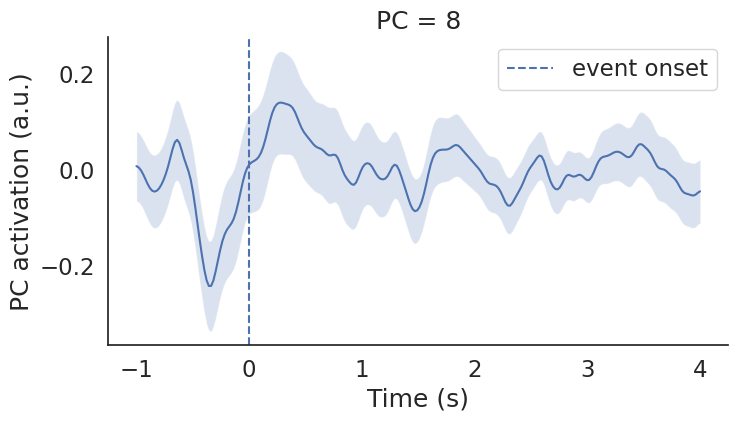

In [22]:
# test a few for 'lick'
timecourse_plot('Lick', 0, -1, 4.)
timecourse_plot('Lick', 1, -1, 4.)
timecourse_plot('Lick', 5, -1, 4.)
timecourse_plot('Lick', 8, -1, 4.)

For the lcik case, it seems that for some PCs (eg. 8 or 0), there is a steady increase in the activation around the time of a lick. For some others, this does not look like something significant.

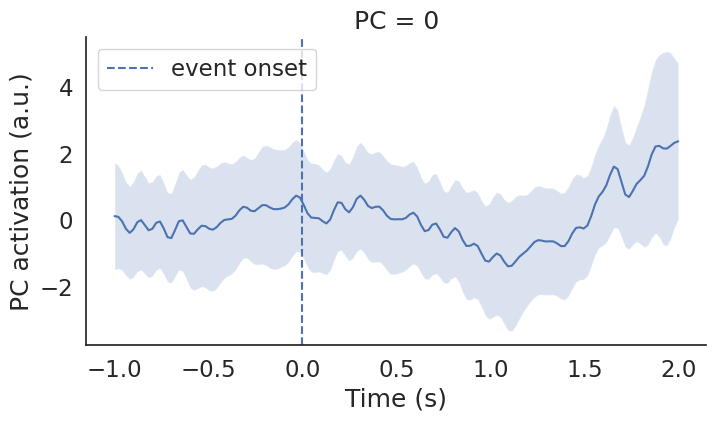

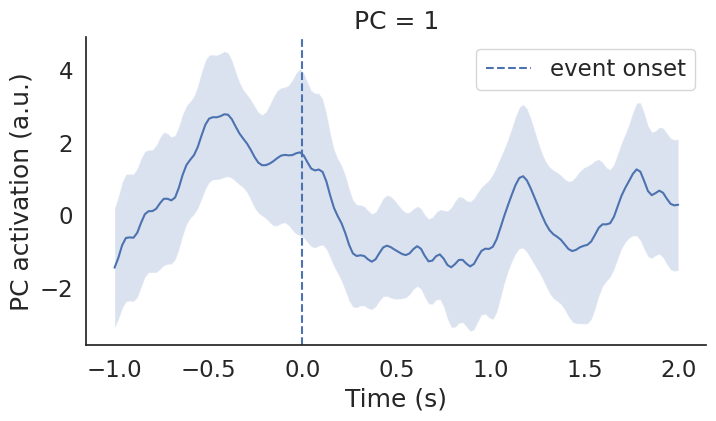

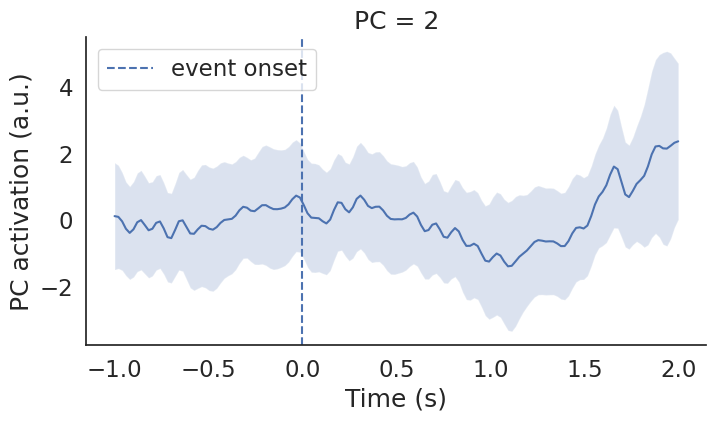

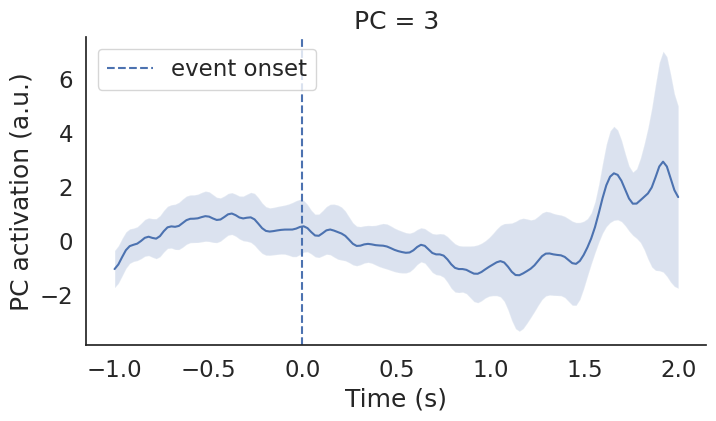

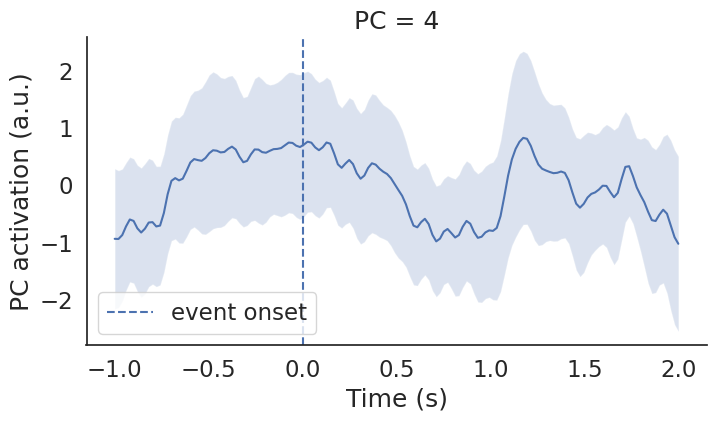

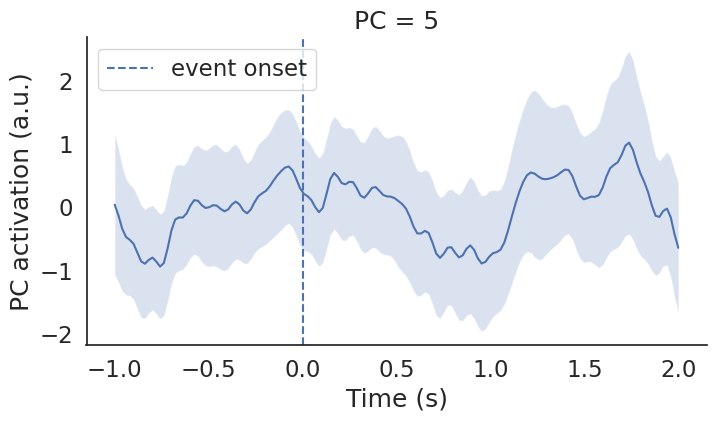

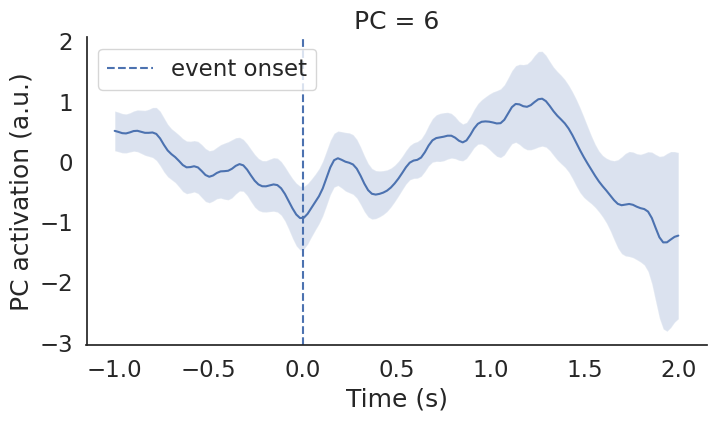

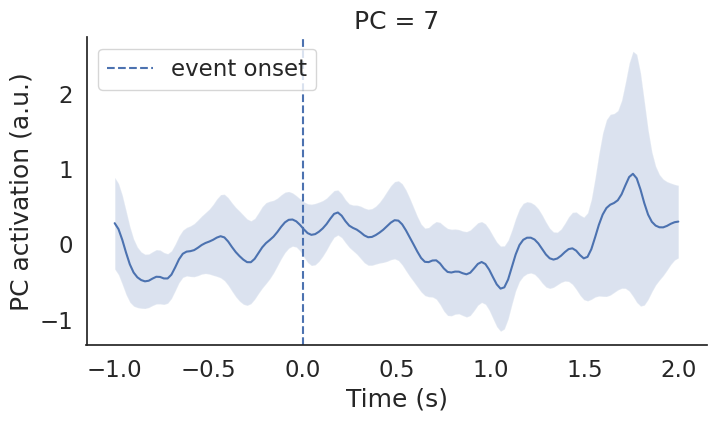

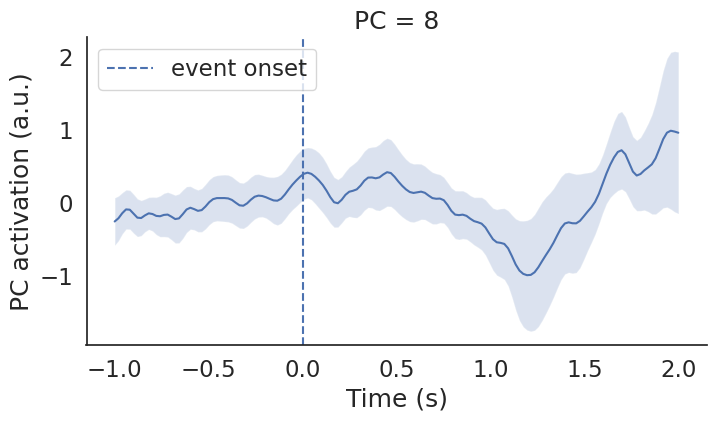

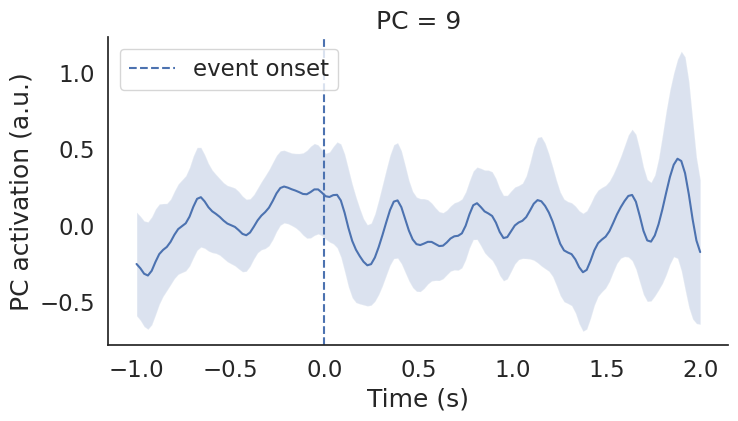

In [23]:
# test first 10 for ''CSp'' around a CSp event
for i in range(10):
  timecourse_plot('CSp', i, -1, 2)

Here again, the seems to be a clear change for some of the PCs (at 6 it goes down and precisely from the event it steadily goes up), but for example PC=0 shows nothing as result of the signal.

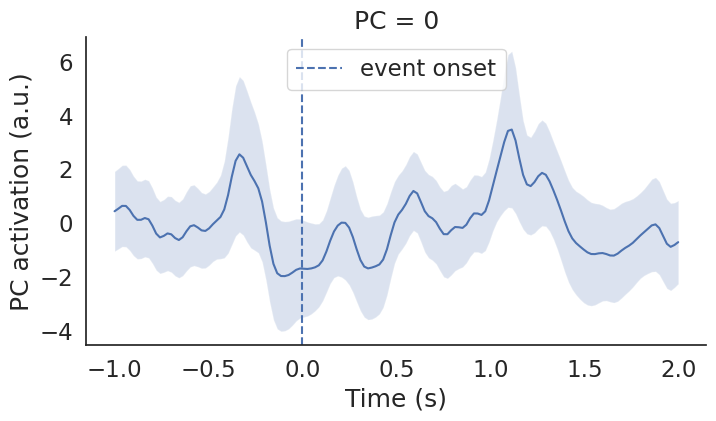

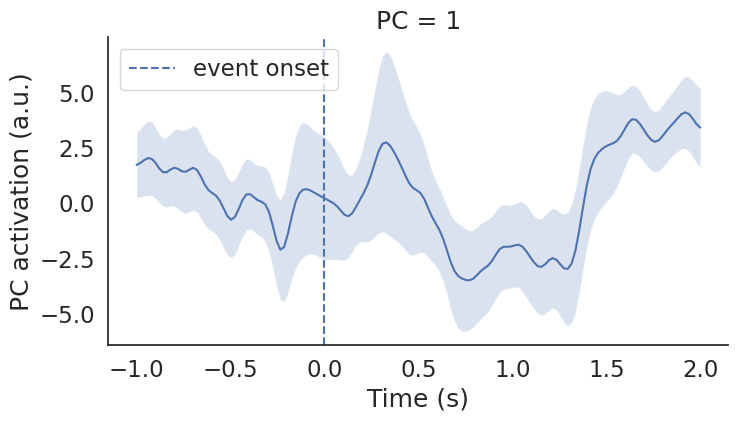

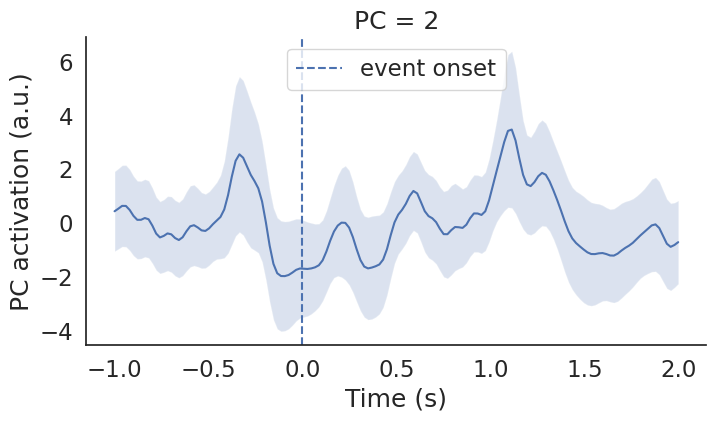

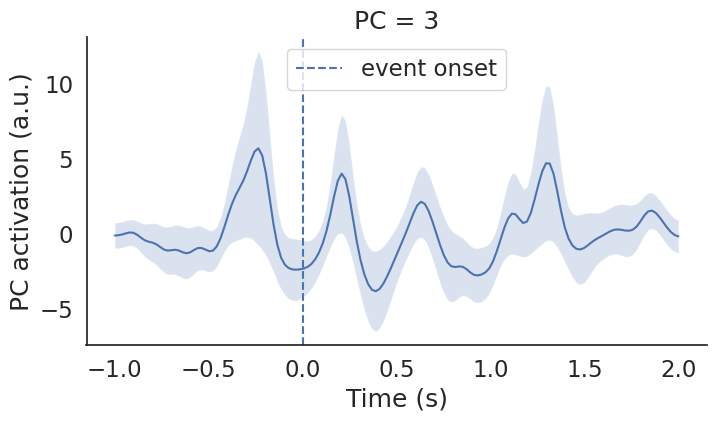

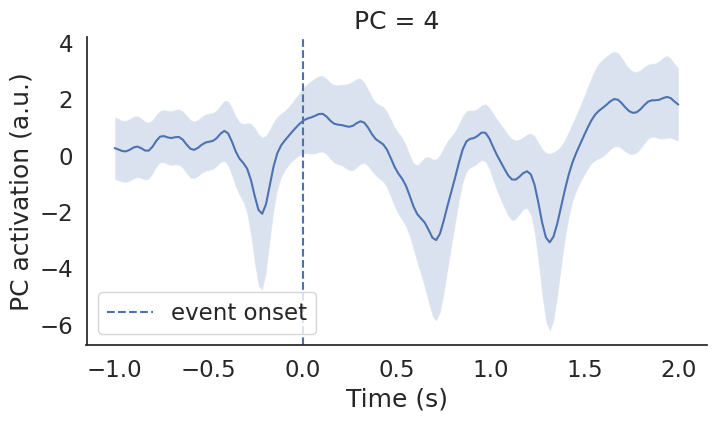

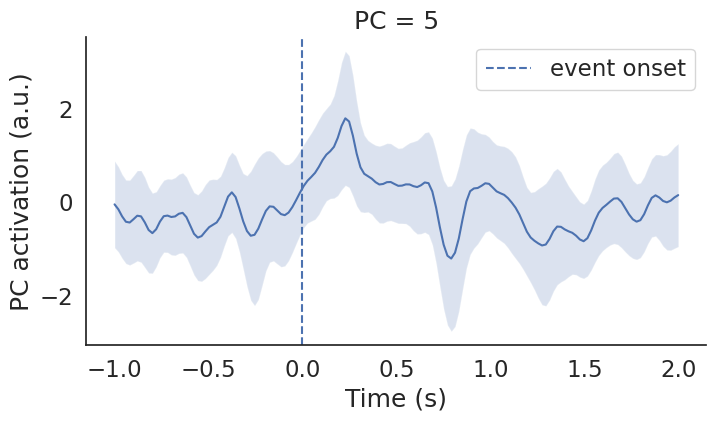

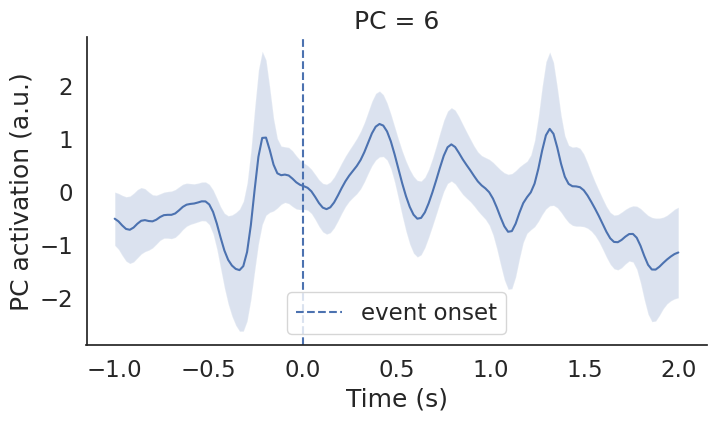

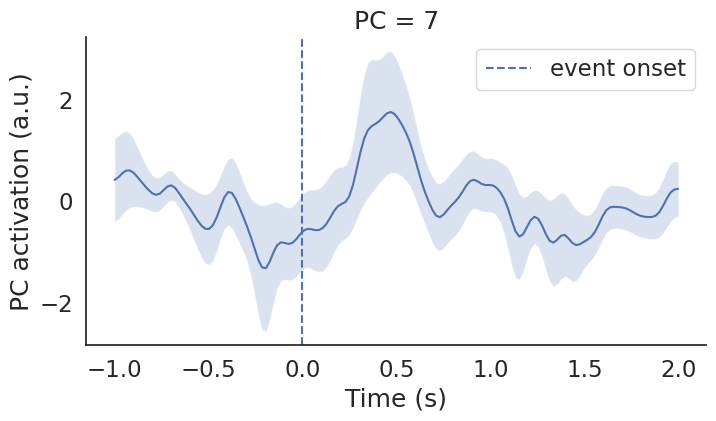

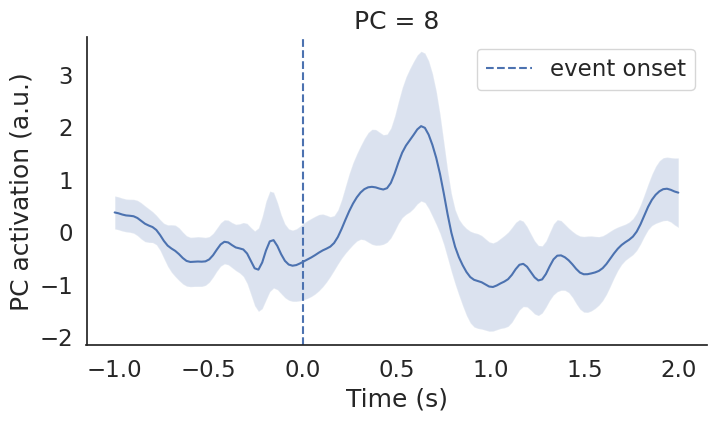

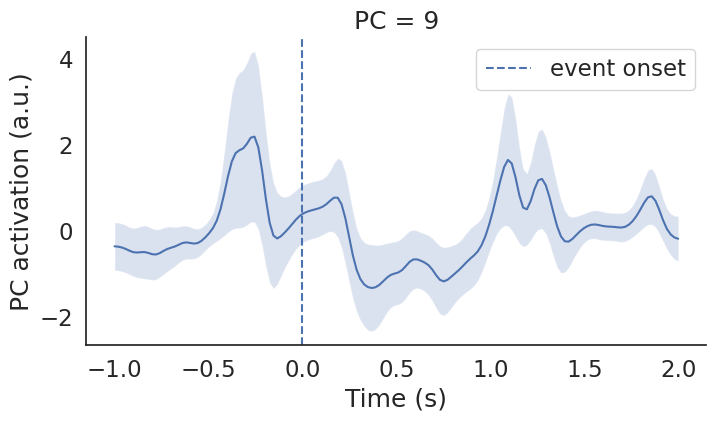

In [24]:
# test first 10 for ''CSn'' around a CSn event
for i in range(10):
  timecourse_plot('CSn', i, -1, 2)

Here again for some PCs (7 and 8) there seems to be some effect. This is interesting as 7 and 8 showed 'no' change for the CSp and now there is no clear change for 6, which did have significance for the CSp.

To test if these PCs actually show something of significance, one could look at the topographic organisation of the PC weights and cross check them to known locations in the brain and their influences on positive/negative events or the part of the motorcortex controling the tongue.

To test for statistical significance, data should be validated by comparing with null-cases and data without quantatative measurements.

## Exercise 3: nonlinear dimensionality reduction

Using the MNIST digit dataset, explore the effect of hyperparameters on the result of nonlinear dimensionality reduction methods.

- Change the `perplexity` and `exageration` parameters in `TNSE` (one at a time). Graphically compare the results of different values.
- Change the neighbourhood size in `Isomap` (set by the parameter `n_neighbors`), and visualize how the results change.

Finally, try to apply one or more of these methods to the cortical data we used in the lessons. How do the data look in two dimensions? Do any cluster seem to appear? Are they robust with respect to hyperparameter choice?

In [ ]:
# load MNIST dataset (same as before)
dataset = load_digits()
images = dataset.data